In [20]:
import pandas as pd
import numpy as np
import ast

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Boeing

In [2]:
df = pd.read_excel('BA_Stock news with sentiment.xlsx')
df = df.dropna(subset=['content'])
df = df.drop(columns=['publisher', 'url', 'title'])
df

,date,content,negative,neutral,positive
0,2024-04-24,Boeing has been mired in a safety crisis since...,0.981807,0.017569,0.000624
1,2024-04-24,Families of the victims of two fatal Boeing 73...,0.653259,0.345061,0.001681
2,2024-04-24,"Merle Meyers, who left Boeing last year after ...",0.000208,0.999556,0.000236
3,2024-04-24,Japan Airlines will continue using both Airbus...,0.000074,0.999808,0.000118
4,2024-04-24,"Bert Subin, Aerospace Analyst at Stifel, gives...",0.000277,0.000226,0.999497
...,...,...,...,...,...
9038,2016-02-26,"NEW YORK, NY--(Marketwired - February 26, 2016...",0.000131,0.999807,0.000062
9039,2016-02-24,"NEW YORK, Feb. 24, 2016 (GLOBE NEWSWIRE) -- ...",0.000141,0.999800,0.000060
9040,2016-02-24,"SAN FRANCISCO, Feb. 24, 2016 (GLOBE NEWSWIRE...",0.857394,0.141325,0.001281
9041,2016-02-22,"NEW YORK, Feb. 22, 2016 (GLOBE NEWSWIRE) -- ...",0.000274,0.999333,0.000393


In [3]:
from span_marker import SpanMarkerModel

model = SpanMarkerModel.from_pretrained("lxyuan/span-marker-bert-base-multilingual-uncased-multinerd")

description = "Singapore is renowned for its hawker centers offering dishes \
like Hainanese chicken rice and laksa, while Malaysia boasts dishes such as \
nasi lemak and rendang, reflecting its rich culinary heritage."

entities = model.predict(description)

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [12]:
# Функция, чтобы отфильтровать только организации
def filter_organizations(entities):
    return [entity for entity in entities if 'ORG' in entity['label']]

In [18]:
def find_entity(example):
    predict = model.predict(example)
    org_entities = filter_organizations(predict)

    stack = []
    # Пройдемся по списку, избегая выхода за пределы индекса
    for i in range(len(org_entities)):
        stack.append(org_entities[i]['span'])
    return stack

In [19]:
df['entities'] = np.nan
df['entities'] = df['content'].apply(find_entity)

In [98]:
df.to_csv('BA_with_entities_model_2.csv', index=False) 

In [100]:
df = pd.read_csv('BA_with_entities_model_2.csv')

In [101]:
df_series = df[0:500]
df_series

,date,content,negative,neutral,positive,entities
0,2024-04-24,Boeing has been mired in a safety crisis since...,0.981807,0.017569,0.000624,['Boeing']
1,2024-04-24,Families of the victims of two fatal Boeing 73...,0.653259,0.345061,0.001681,[]
2,2024-04-24,"Merle Meyers, who left Boeing last year after ...",0.000208,0.999556,0.000236,['Boeing']
3,2024-04-24,Japan Airlines will continue using both Airbus...,0.000074,0.999808,0.000118,"['Japan Airlines', 'Airbus', 'Boeing']"
4,2024-04-24,"Bert Subin, Aerospace Analyst at Stifel, gives...",0.000277,0.000226,0.999497,"['Stifel', 'Boeing']"
...,...,...,...,...,...,...
495,2024-02-15,"Boeing's margins are expanding, and cash flow ...",0.000205,0.000099,0.999696,['Boeing']
496,2024-02-15,Airbus has announced a special dividend follow...,0.000257,0.000280,0.999463,['Airbus']
497,2024-02-15,Delta CEO Ed Bastian told FOX Business that Bo...,0.000171,0.999746,0.000084,"['Delta', 'FOX Business', 'Boeing', 'Airbus', ..."
498,2024-02-14,Thai Airways International said on Wednesday i...,0.000269,0.000191,0.999540,"['Thai Airways International', 'Boeing', 'GE A..."


In [82]:
df_series_positive = df_series[df_series['positive'] > 0.5 ]
df_series_positive

,date,content,negative,neutral,positive,entities
4,2024-04-24,"Bert Subin, Aerospace Analyst at Stifel, gives...",0.000277,0.000226,0.999497,"[Stifel, Boeing]"
5,2024-04-24,"Boeing Co (NYSE:BA, ETR:BCO) could be set to e...",0.000194,0.000098,0.999708,[Boeing Co]
7,2024-04-24,Boeing Co (NYSE: BA) is trading up in premarke...,0.000251,0.000097,0.999653,[Boeing Co]
8,2024-04-24,Boeing reported an adjusted loss per share of ...,0.080769,0.001109,0.918123,"[Boeing, Bloomberg]"
9,2024-04-24,CNBC's Phil LeBeau joins 'Squawk Box' to repor...,0.000229,0.000103,0.999668,[CNBC]
...,...,...,...,...,...,...
494,2024-02-16,Intuitive Machines Inc.'s historic attempt to ...,0.000486,0.022447,0.977067,[Intuitive Machines Inc.]
495,2024-02-15,"Boeing's margins are expanding, and cash flow ...",0.000205,0.000099,0.999696,[Boeing]
496,2024-02-15,Airbus has announced a special dividend follow...,0.000257,0.000280,0.999463,[Airbus]
498,2024-02-14,Thai Airways International said on Wednesday i...,0.000269,0.000191,0.999540,"[Thai Airways International, Boeing, GE Aerosp..."


In [83]:
df_series_negative = df_series[df_series['negative'] > 0.5 ]
df_series_negative

,date,content,negative,neutral,positive,entities
0,2024-04-24,Boeing has been mired in a safety crisis since...,0.981807,0.017569,0.000624,[Boeing]
1,2024-04-24,Families of the victims of two fatal Boeing 73...,0.653259,0.345061,0.001681,[]
6,2024-04-24,Boeing's lower 737 MAX production will slow th...,0.998323,0.000882,0.000795,[Boeing]
12,2024-04-24,Boeing's (BA) Q1 revenues of $16.57 billion mi...,0.998757,0.000760,0.000483,[Boeing]
13,2024-04-24,Boeing (BA) came out with a quarterly loss of ...,0.927123,0.000366,0.072511,"[Boeing, Zacks]"
...,...,...,...,...,...,...
482,2024-02-20,Ryanair expects to be at least seven Boeing de...,0.980046,0.019390,0.000564,"[Ryanair, Boeing, Reuters]"
485,2024-02-20,Ryanair boss Michael O' Leary said the problem...,0.997931,0.001578,0.000491,"[Ryanair, Boeing]"
486,2024-02-20,Boeing booked orders for three airplanes in Ja...,0.995802,0.001144,0.003053,[Boeing]
492,2024-02-17,The postponing of 2024 guidance raises questio...,0.995707,0.003825,0.000468,[Boeing]


In [88]:
df_series_positive['entities']

4                                       [Stifel, Boeing]
5                                            [Boeing Co]
7                                            [Boeing Co]
8                                    [Boeing, Bloomberg]
9                                                 [CNBC]
                             ...                        
494                            [Intuitive Machines Inc.]
495                                             [Boeing]
496                                             [Airbus]
498    [Thai Airways International, Boeing, GE Aerosp...
499                            [Alaska Airlines, Boeing]
Name: entities, Length: 122, dtype: object

## Облако позитивного упоминания компаний

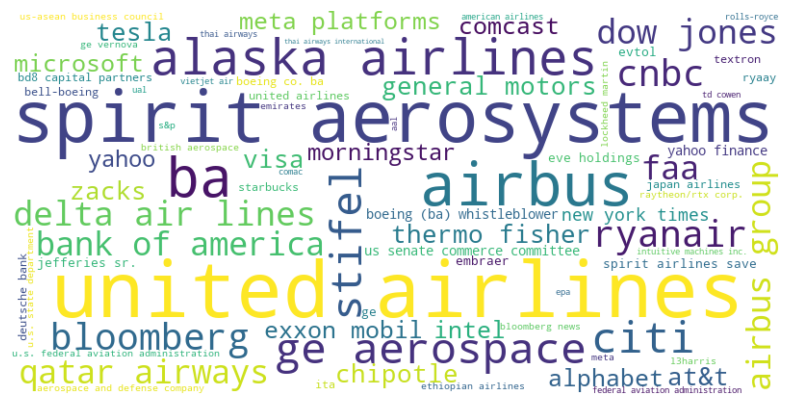

In [104]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'Boeing', 'Boeing Co', 'Boeing Co.', 'boeing', 'boeing co', 'boeing co.'}

# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_series_positive['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение


## Облако негативного упоминания компаний

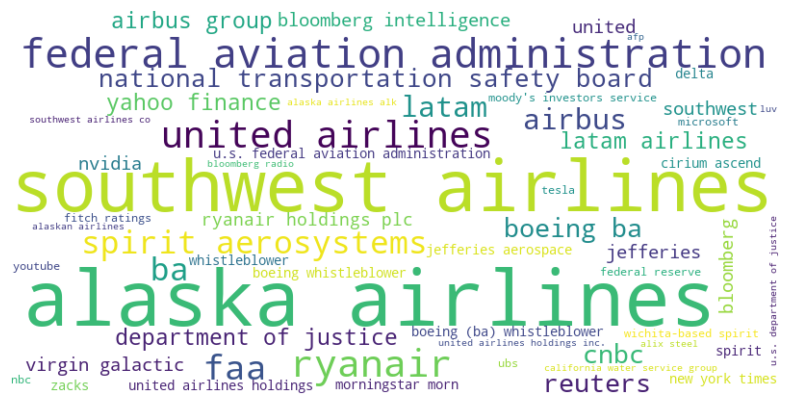

In [105]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'Boeing', 'Boeing Co', 'Boeing Co.', 'boeing', 'boeing co', 'boeing co.'}

# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_series_negative['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение


In [24]:
# def str_tolist(text):
#     actual_list = ast.literal_eval(text)
#     return actual_list

In [27]:
# df_series['entities'] = df_series['entities'].apply(str_tolist)
# df_series

ValueError: malformed node or string: ['Boeing']

In [28]:
data_tickers = pd.read_csv('data_tickers.csv')

In [29]:
data_tickers_name = data_tickers['name'].to_list()

In [30]:
df_series = df_series.reset_index(drop=True)

In [32]:
df_series

,date,content,negative,neutral,positive,entities
0,2024-04-24,Boeing has been mired in a safety crisis since...,0.981807,0.017569,0.000624,[Boeing]
1,2024-04-24,Families of the victims of two fatal Boeing 73...,0.653259,0.345061,0.001681,[]
2,2024-04-24,"Merle Meyers, who left Boeing last year after ...",0.000208,0.999556,0.000236,[Boeing]
3,2024-04-24,Japan Airlines will continue using both Airbus...,0.000074,0.999808,0.000118,"[Japan Airlines, Airbus, Boeing]"
4,2024-04-24,"Bert Subin, Aerospace Analyst at Stifel, gives...",0.000277,0.000226,0.999497,"[Stifel, Boeing]"
...,...,...,...,...,...,...
95,2024-04-11,The U.S. Federal Aviation Administration has p...,0.002181,0.950126,0.047693,[U.S. Federal Aviation Administration]
96,2024-04-11,"When deciding whether to buy, sell, or hold a ...",0.000636,0.021889,0.977475,[]
97,2024-04-11,Boeing stock closed at a new 52-week low on We...,0.995870,0.003784,0.000346,[Boeing]
98,2024-04-11,Boeing's Latin America President Landon Loomis...,0.928619,0.043629,0.027751,[Boeing]


## Pipeline

In [33]:
df_series['tickers'] = np.nan
df_series

,date,content,negative,neutral,positive,entities,tickers
0,2024-04-24,Boeing has been mired in a safety crisis since...,0.981807,0.017569,0.000624,[Boeing],NaN
1,2024-04-24,Families of the victims of two fatal Boeing 73...,0.653259,0.345061,0.001681,[],NaN
2,2024-04-24,"Merle Meyers, who left Boeing last year after ...",0.000208,0.999556,0.000236,[Boeing],NaN
3,2024-04-24,Japan Airlines will continue using both Airbus...,0.000074,0.999808,0.000118,"[Japan Airlines, Airbus, Boeing]",NaN
4,2024-04-24,"Bert Subin, Aerospace Analyst at Stifel, gives...",0.000277,0.000226,0.999497,"[Stifel, Boeing]",NaN
...,...,...,...,...,...,...,...
95,2024-04-11,The U.S. Federal Aviation Administration has p...,0.002181,0.950126,0.047693,[U.S. Federal Aviation Administration],NaN
96,2024-04-11,"When deciding whether to buy, sell, or hold a ...",0.000636,0.021889,0.977475,[],NaN
97,2024-04-11,Boeing stock closed at a new 52-week low on We...,0.995870,0.003784,0.000346,[Boeing],NaN
98,2024-04-11,Boeing's Latin America President Landon Loomis...,0.928619,0.043629,0.027751,[Boeing],NaN


In [34]:
for index in range(len(df_series)):
    # Выполняем fuzzy matching для извлечения потенциальных компаний
    extraction_results = process.extract(str(df_series['entities'][index]), data_tickers_name, limit=5)

    # Фильтруем компании со score >= 75
    matching_companies = [company for company, score in extraction_results if score >= 87]

    if matching_companies:
        # Получаем коды компаний, соответствующие matching_companies
        matching_codes = [data_tickers[data_tickers['name'] == company]['code'].values[0] for company in matching_companies]

        codes_str = ", ".join(matching_codes)

        df_series['tickers'].iloc[index] = codes_str

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_23941/22154879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['tickers'].iloc[index] = codes_str
/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_23941/22154879.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'BA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_series['tickers'].iloc[index] = codes_str


In [35]:
df_series['tickers'].value_counts()

tickers
BA                             44
UAL                             8
BAC                             1
V                               1
DOW                             1
NVDA                            1
UAL, UNH, UPS, URI, UTDI.DE     1
NYT                             1
LUV                             1
Name: count, dtype: int64

## Валидация

In [165]:
all_data_tickers = pd.read_csv('List_tickers.csv', delimiter=';')
all_data_tickers = all_data_tickers[['ticker', 'company']]
all_data_tickers['company'] = all_data_tickers['company'].str.lower()
all_data_tickers

,ticker,company
0,MAPT4.SA,cemepe investimentos s.a.
1,CPLE3.SA,companhia paranaense de energia - copel
2,CPLE6.SA,companhia paranaense de energia - copel
3,POM.TO,polymet mining corp.
4,PTM.TO,platinum group metals ltd.
...,...,...
52015,ELC,"entergy louisiana, llc collateral tr mt"
52016,WRLGF,west red lake gold mines ltd.
52017,TUXS,tuxis corporation
52018,GHTI,g-h-3 international inc.


In [167]:
data_tickers_name = all_data_tickers['company'].to_list()
data_tickers_name

['cemepe investimentos s.a.',
 'companhia paranaense de energia - copel',
 'companhia paranaense de energia - copel',
 'polymet mining corp.',
 'platinum group metals ltd.',
 'minupar participaáıes s.a.',
 's„o martinho s.a.',
 'ultrapar participaáıes s.a.',
 'petrûleo brasileiro s.a. - petrobras',
 'cielo s.a.',
 'natura &co holding s.a.',
 'unipar carbocloro s.a.',
 'banco bradesco s.a.',
 'banco bradesco s.a.',
 'weg s.a.',
 'fleury s.a.',
 'cyrela brazil realty s.a. empreendimentos e participaáıes',
 'inepar s.a. ind˙stria e construáıes',
 'orizon valorizaá„o de resìduos s.a.',
 'mèliuz s.a.',
 'ccr s.a.',
 'b3 s.a. - brasil, bolsa, balc„o',
 'ita˙sa s.a.',
 'americanas s.a.',
 'locaweb serviáos de internet s.a.',
 'moura dubeux engenharia s.a.',
 'sendas distribuidora s.a.',
 'cogna educaá„o s.a.',
 'cia de ferro ligas da bahia - ferbasa',
 'yduqs participaáıes s.a.',
 'log-in logìstica intermodal s.a.',
 'boa vista serviáos s.a.',
 'braskem s.a.',
 'iguatemi s.a.',
 'centro de im

In [39]:
df_val = pd.read_csv('BA_news_val.csv')
df_val = df_val[['date', 'title', 'content', 'tickersMentioned']]
df_val = df_val.dropna(subset=['tickersMentioned'])
df_val = df_val[0:300]

In [40]:
df_val['entities'] = df_val['content'].apply(find_entity)
df_val

,date,title,content,tickersMentioned,entities
0,2024-01-10,UPDATE 1-Boeing hits 2023 jet delivery goal bu...,"(Recasts with Airbus comparison, adds market s...","['AIR.F', 'AIR.MC', 'AIR.PA', 'AIR.XETRA', 'AI...","[Airbus, Reuters, Boeing, Airbus, Boeing, Spir..."
10,2024-01-10,Bitcoin’s Respectability Takes a Fresh Hit Wit...,Boeing CEO acknowledges ‘mistake’ after Alaska...,"['ALK.F', 'ALK.US', 'BA.MX', 'BA.US', 'BCO.F',...","[Boeing, World Bank]"
11,2024-01-10,MORNING BID AMERICAS-Japan shines as Wall St e...,A look at the day ahead in U.S. and global mar...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[Bank of Japan, G7]"
12,2024-01-10,PRESS DIGEST- Wall Street Journal - Jan 10,Jan 10 (Reuters) - The following are the top s...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[Reuters, Reuters, bitcoin, Boeing, Sonos, Int..."
13,2024-01-10,"Futures broadly higher, Bitcoin swings after f...",Investing.com -- U.S. stock futures were mostl...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[Securities and Exchange Commission, Boeing]"
...,...,...,...,...,...
437,2023-12-04,Maersk Air Cargo explores China-UK route,A Boeing 767-300 freighter in the Maersk Air C...,"['AMKAF.US', 'AMKBF.US', 'AMKBY.US', 'BA.MX', ...","[ocean shipping company, Maersk Air Cargo]"
443,2023-12-01,Exclusive-Boeing eliminated from US Air Force'...,By Valerie Insinna and Mike Stone\n\nWASHINGTO...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[Reuters, U.S. Air Force, Boeing, Boeing, Sier..."
444,2023-12-01,Boeing could see positive 2023 driven by fleet...,Aerospace manufacturer Boeing (BA) is flying h...,"['AIR.F', 'AIR.MC', 'AIR.MI', 'AIR.PA', 'AIR.X...","[Boeing, Boeing, Boeing, Yahoo]"
445,2023-12-01,Buy Boeing Stock and Don’t Worry About a Reces...,Stifel analyst Bert Subin launches coverage of...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...",[]


In [174]:
# Если 'entities' содержит списки строк, применим 'lower' ко всем строкам в этих списках
df_val['entities'] = df_val['entities'].apply(lambda x: [item.lower() for item in x] if isinstance(x, list) else x)
df_val

,date,title,content,tickersMentioned,entities,tickers
0,2024-01-10,UPDATE 1-Boeing hits 2023 jet delivery goal bu...,"(Recasts with Airbus comparison, adds market s...","['AIR.F', 'AIR.MC', 'AIR.PA', 'AIR.XETRA', 'AI...","[airbus, reuters, boeing, airbus, boeing, spir...","BA, AIR.PA"
1,2024-01-10,Bitcoin’s Respectability Takes a Fresh Hit Wit...,Boeing CEO acknowledges ‘mistake’ after Alaska...,"['ALK.F', 'ALK.US', 'BA.MX', 'BA.US', 'BCO.F',...","[boeing, world bank]","MTB, 0939.HK, 1398.HK"
2,2024-01-10,MORNING BID AMERICAS-Japan shines as Wall St e...,A look at the day ahead in U.S. and global mar...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[bank of japan, g7]","MTB, PKG, 0939.HK"
3,2024-01-10,PRESS DIGEST- Wall Street Journal - Jan 10,Jan 10 (Reuters) - The following are the top s...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[reuters, reuters, bitcoin, boeing, sonos, int...","BA, MMI"
4,2024-01-10,"Futures broadly higher, Bitcoin swings after f...",Investing.com -- U.S. stock futures were mostl...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[securities and exchange commission, boeing]","BA, ICE, FRE.DE"
...,...,...,...,...,...,...
295,2023-12-04,Maersk Air Cargo explores China-UK route,A Boeing 767-300 freighter in the Maersk Air C...,"['AMKAF.US', 'AMKBF.US', 'AMKBY.US', 'BA.MX', ...","[ocean shipping company, maersk air cargo]","APD, ALK, BA"
296,2023-12-01,Exclusive-Boeing eliminated from US Air Force'...,By Valerie Insinna and Mike Stone\n\nWASHINGTO...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[reuters, u.s. air force, boeing, boeing, sier...","APD, ALK, ALL"
297,2023-12-01,Boeing could see positive 2023 driven by fleet...,Aerospace manufacturer Boeing (BA) is flying h...,"['AIR.F', 'AIR.MC', 'AIR.MI', 'AIR.PA', 'AIR.X...","[boeing, boeing, boeing, yahoo]",BA
298,2023-12-01,Buy Boeing Stock and Don’t Worry About a Reces...,Stifel analyst Bert Subin launches coverage of...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...",[],NaN


In [175]:
extraction_results = process.extract(str(df_val['entities'][0]), data_tickers_name, limit=5)
extraction_results

[('spirit aerosystems holdings, inc.', 86),
 ('the boeing company', 86),
 ('thomson reuters corporation', 86),
 ('spirit airlines, inc.', 86),
 ('spirit realty capital, inc.', 86)]

In [176]:
df_val['tickers'] = np.nan
df_val.head(3)

,date,title,content,tickersMentioned,entities,tickers
0,2024-01-10,UPDATE 1-Boeing hits 2023 jet delivery goal bu...,"(Recasts with Airbus comparison, adds market s...","['AIR.F', 'AIR.MC', 'AIR.PA', 'AIR.XETRA', 'AI...","[airbus, reuters, boeing, airbus, boeing, spir...",NaN
1,2024-01-10,Bitcoin’s Respectability Takes a Fresh Hit Wit...,Boeing CEO acknowledges ‘mistake’ after Alaska...,"['ALK.F', 'ALK.US', 'BA.MX', 'BA.US', 'BCO.F',...","[boeing, world bank]",NaN
2,2024-01-10,MORNING BID AMERICAS-Japan shines as Wall St e...,A look at the day ahead in U.S. and global mar...,"['BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI...","[bank of japan, g7]",NaN


In [177]:
df_val = df_val.reset_index(drop=True)

In [178]:
extraction_results = process.extract(str(df_val['entities'][3]), data_tickers_name, limit=5)
extraction_results

[('the boeing company', 86),
 ('thomson reuters corporation', 86),
 ('intel corporation', 86),
 ('blade air mobility, inc.', 86),
 ('thomson reuters corporation', 86)]

In [179]:
all_data_tickers

,ticker,company
0,MAPT4.SA,cemepe investimentos s.a.
1,CPLE3.SA,companhia paranaense de energia - copel
2,CPLE6.SA,companhia paranaense de energia - copel
3,POM.TO,polymet mining corp.
4,PTM.TO,platinum group metals ltd.
...,...,...
52015,ELC,"entergy louisiana, llc collateral tr mt"
52016,WRLGF,west red lake gold mines ltd.
52017,TUXS,tuxis corporation
52018,GHTI,g-h-3 international inc.


In [191]:
for index in range(len(df_val)):
    # Выполняем fuzzy matching для извлечения потенциальных компаний
    extraction_results = process.extract(str(df_val['entities'][index]), data_tickers_name, limit=3)

    # Фильтруем компании со score >= 87
    matching_companies = [company for company, score in extraction_results if score >= 80]

    if matching_companies:
        # Получаем коды компаний, соответствующие matching_companies
        matching_codes = [all_data_tickers[all_data_tickers['company'] == company]['ticker'].values[0] for company in matching_companies]

        codes_str = ", ".join(matching_codes)

        df_val['tickers'].iloc[index] = codes_str

## Сколько строк с распознанными тикерами

In [183]:
extraction_results = process.extract(str(df_val['entities'][0]), data_tickers_name, limit=3)
extraction_results

[('spirit aerosystems holdings, inc.', 86),
 ('the boeing company', 86),
 ('thomson reuters corporation', 86)]

In [190]:
df_val['tickersMentioned'][0]

"['AIR.F', 'AIR.MC', 'AIR.PA', 'AIR.XETRA', 'AIRA.F', 'BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI34.SA', 'EADSF.US', 'EADSY.US']"

In [153]:
df_val['tickers'][0]

'BA, AIR.PA'

In [152]:
df_val['tickersMentioned'][0]

"['AIR.F', 'AIR.MC', 'AIR.PA', 'AIR.XETRA', 'AIRA.F', 'BA.MX', 'BA.US', 'BCO.F', 'BCO.XETRA', 'BOEI34.SA', 'EADSF.US', 'EADSY.US']"

In [147]:
set([x for xs in df_val['entities'] for x in xs])

{'A.C. Roman and Associates',
 'AAPL',
 'AAR',
 'AAR Corp. AIR',
 'AFAC',
 'AJ Bell',
 'ALASKA AIRLINES',
 'AMD',
 'AP',
 'ARM',
 'ASL Airlines Belgium',
 'ASL Airlines France',
 'ASL Airlines Ireland',
 'ASL Airlines United Kingdom',
 'ASL Aviation Holdings DAC',
 'ASSOCIATED PRESS',
 'Advanced Micro Devices',
 'AerCap',
 'Aeromexico',
 'Air Force',
 'Air Force Life Cycle Management Center',
 'Air Space Intelligence Inc',
 'Airbus',
 'Airbus SE',
 'Al-Udeid',
 'Alaksa Airlines',
 'Alaska',
 'Alaska Air',
 'Alaska Air Group',
 'Alaska Airlines',
 'Alaska Airlines flight',
 'Alaska and United',
 'Alaskan Airlines',
 'Alphabet',
 'Amazon',
 'Amazon Prime Video',
 'Amazon.com',
 'American Airlines',
 'American Express',
 'American Express Co.',
 'American Express Co. AXP',
 'American States Water',
 'American eVTOL',
 'Amgen',
 'Anduril',
 'Anduril Industries',
 'Anirud',
 'Apple',
 'Apple Inc.',
 'Apple Inc. AAPL',
 'Archer Aviation',
 'Archer Aviation Inc',
 'Archer Aviation Inc.',
 'As

In [64]:
df_val['entities'][299]

['Embraer S.A. ERJ', 'Porter Airlines']

In [66]:
extraction_results = process.extract(str(df_val['entities'][299]), data_tickers_name, limit=3)
extraction_results

[('alphabet inc. (class a)', 86),
 ('american airlines group', 86),
 ('a. o. smith', 86)]

In [61]:
len(df_val['tickers']) - df_val['tickers'].isna().sum()

259

# NVIDIA

In [127]:
df_nvidia = pd.read_excel('NVDA_Stock news with sentiment.xlsx')
df_nvidia = df_nvidia.dropna(subset=['content'])
df_nvidia = df_nvidia.drop(columns=['publisher', 'url', 'title'])
df_nvidia = df_nvidia[0:500]
df_nvidia

,date,content,negative,neutral,positive
0,2024-04-24,It's still hard to believe that one of the bes...,0.000518,0.007856,0.991626
1,2024-04-24,The Tesla CEO talked about demand for Nvidia c...,0.000477,0.000378,0.999144
2,2024-04-24,NVIDIA Corp (NASDAQ:NVDA) stock has more than ...,0.000251,0.000159,0.999590
3,2024-04-24,"Nvidia is acquiring Run:ai, a startup that mak...",0.000197,0.001957,0.997846
4,2024-04-23,Nvidia Corporation slumped 10% last Friday wit...,0.998129,0.000340,0.001530
...,...,...,...,...,...
495,2024-03-11,Futures at the start of the week suggest the s...,0.994414,0.004361,0.001225
496,2024-03-11,Nvidia (NASDAQ: NVDA ) stock is a hot topic on...,0.000224,0.000617,0.999159
497,2024-03-11,Nvidia is going through a renaissance as deman...,0.000246,0.000157,0.999597
498,2024-03-11,"C.J. Muse, Cantor Fitzgerald analyst, joins 'S...",0.000477,0.021682,0.977841


In [128]:
df_nvidia['entities'] = np.nan
df_nvidia['entities'] = df_nvidia['content'].apply(find_entity)

In [129]:
df_nvidia.to_csv('NVIDIA_with_entities_model_2.csv', index=False) 

In [130]:
df_nvidia_positive = df_nvidia[df_nvidia['positive'] > 0.5 ]
df_nvidia_positive

,date,content,negative,neutral,positive,entities
0,2024-04-24,It's still hard to believe that one of the bes...,0.000518,0.007856,0.991626,[Nvidia]
1,2024-04-24,The Tesla CEO talked about demand for Nvidia c...,0.000477,0.000378,0.999144,"[Tesla, Nvidia]"
2,2024-04-24,NVIDIA Corp (NASDAQ:NVDA) stock has more than ...,0.000251,0.000159,0.999590,[NVIDIA Corp]
3,2024-04-24,"Nvidia is acquiring Run:ai, a startup that mak...",0.000197,0.001957,0.997846,"[Nvidia, Ctech]"
6,2024-04-23,Last year marked an incredible turnaround for ...,0.000245,0.000084,0.999671,[Amazon]
...,...,...,...,...,...,...
492,2024-03-11,In addition to their well-defined competitive ...,0.040909,0.266693,0.692398,[Nvidia]
493,2024-03-11,"Nvidia was rising early on Monday, finding its...",0.000529,0.000139,0.999332,[Nvidia]
496,2024-03-11,Nvidia (NASDAQ: NVDA ) stock is a hot topic on...,0.000224,0.000617,0.999159,"[Nvidia, Cantor Fitzgerald]"
497,2024-03-11,Nvidia is going through a renaissance as deman...,0.000246,0.000157,0.999597,"[Nvidia, Nvidia]"


## Облако позитивных упоминаний

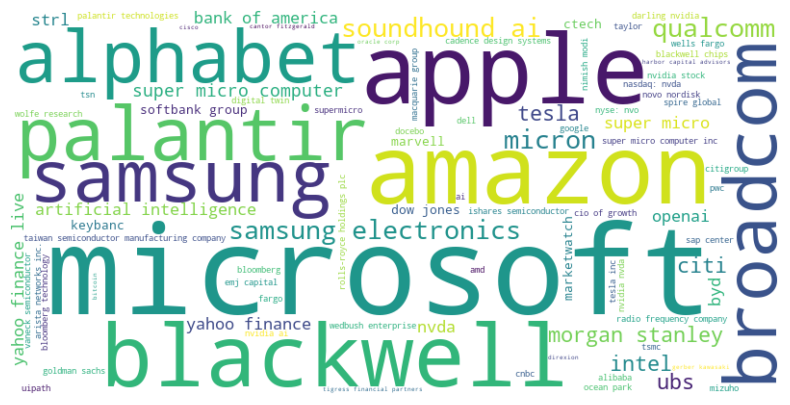

In [135]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'NVIDIA', 'Nvidia', 'NVIDIA Corp', 'nvidia', 'nvidia corp', 'nvidia corp.', 'nvidia corporation', 'zacks', 'oracle'}
# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_nvidia_positive['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение


## Облако негативных упоминаний

In [132]:
df_nvidia_negative = df_nvidia[df_nvidia['negative'] > 0.5 ]
df_nvidia_negative

,date,content,negative,neutral,positive,entities
4,2024-04-23,Nvidia Corporation slumped 10% last Friday wit...,0.998129,0.000340,0.001530,"[Nvidia Corporation, Super Micro Computer]"
8,2024-04-23,TSMC's dim outlook for the semiconductor secto...,0.998228,0.000541,0.001231,[Nvidia]
9,2024-04-23,"Nvidia has fallen 14% over the last month, a l...",0.998098,0.000325,0.001577,[Nvidia]
20,2024-04-22,Following the worst daily drop for Nvidia Corp...,0.997732,0.001336,0.000932,[Nvidia Corp.]
21,2024-04-22,The recent phase in the stock market has been ...,0.998448,0.000849,0.000703,[]
...,...,...,...,...,...,...
478,2024-03-12,The last few trading days have sent jitters do...,0.998334,0.000464,0.001203,[Nvidia]
482,2024-03-12,As Nvidia (NASDAQ: NVDA) stock dipped below th...,0.997564,0.001972,0.000464,[Nvidia]
494,2024-03-11,A look at the day ahead in U.S. and global mar...,0.983278,0.014691,0.002031,[]
495,2024-03-11,Futures at the start of the week suggest the s...,0.994414,0.004361,0.001225,[]


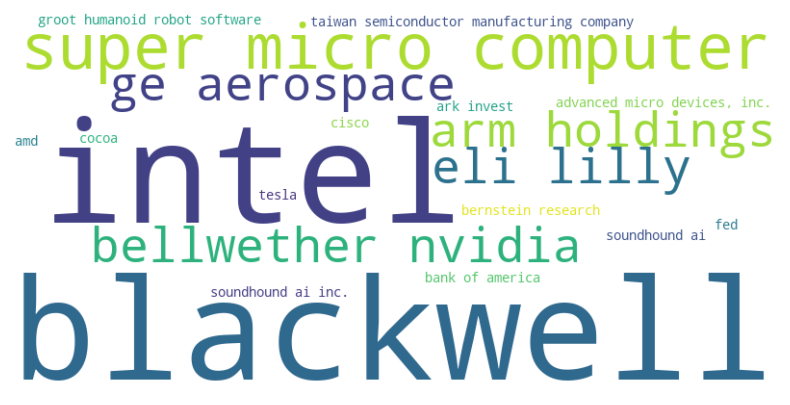

In [133]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'NVIDIA', 'Nvidia', 'NVIDIA Corp', 'nvidia', 'nvidia corp', 'nvidia corp.', 'nvidia corporation'}
# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_nvidia_negative['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение


# Apple

In [117]:
df_apple = pd.read_excel('AAPL_Stock news with sentiment.xlsx')
df_apple = df_apple.dropna(subset=['content'])
df_apple = df_apple.drop(columns=['publisher', 'url', 'title'])
df_apple = df_apple[0:300]
df_apple

,date,content,negative,neutral,positive
0,2024-04-24,Apple Apple is expected to publish its Q2 FY'2...,0.998367,0.000891,0.000742
1,2024-04-24,Apple and Epic Games are heading back to court...,0.023462,0.960525,0.016013
2,2024-04-24,Doubling Down On Telus In Smith Maneuver - Mar...,0.997623,0.001717,0.000660
3,2024-04-24,"Apple Inc (NASDAQ:AAPL, ETR:APC) is cutting 20...",0.998219,0.001276,0.000505
4,2024-04-24,Spotify said today that it has submitted a new...,0.000095,0.999640,0.000265
...,...,...,...,...,...
295,2024-04-03,A powerful earthquake in Taiwan forced chip ma...,0.994470,0.004641,0.000890
296,2024-04-03,From a Department of Justice lawsuit to slowin...,0.990349,0.000455,0.009196
297,2024-04-02,The stock market is dragging Monday's losses i...,0.997959,0.001121,0.000920
298,2024-04-02,"Apple (AAPL), TSMC (TSM), and Exxon Mobil (XOM...",0.699979,0.297824,0.002196


In [118]:
df_apple['entities'] = np.nan
df_apple['entities'] = df_apple['content'].apply(find_entity)

In [119]:
df_apple.to_csv('Apple_with_entities_model_2.csv', index=False) 

## Облако позитивных упоминаний

In [120]:
df_apple_positive = df_apple[df_apple['positive'] > 0.5 ]
df_apple_positive

,date,content,negative,neutral,positive,entities
27,2024-04-23,ROKU's first-quarter 2024 performance is expec...,0.000231,0.000092,0.999677,[Roku Channel]
28,2024-04-23,Investment strategies of billionaires like Buf...,0.000478,0.000886,0.998635,"[Buffett, Griffin]"
30,2024-04-23,Apple (AAPL) has an impressive earnings surpri...,0.000241,0.000228,0.999530,[Apple]
34,2024-04-23,Apple has stepped up its foray into artificial...,0.000336,0.005239,0.994425,"[Apple, Datakalab, European Commission, French..."
36,2024-04-22,Intel is potentially the best-valued chip stoc...,0.000629,0.047264,0.952107,"[Intel, Apple]"
...,...,...,...,...,...,...
283,2024-04-03,"Dell Technologies Inc. DELL, +8.56% was a hot ...",0.000234,0.000107,0.999660,"[Dell Technologies Inc., DELL]"
285,2024-04-03,"For every tech success story, there are countl...",0.038463,0.001620,0.959917,[Apple]
287,2024-04-03,Apple researchers have unveiled an artificial ...,0.000331,0.002969,0.996700,[Apple]
291,2024-04-03,"Starting in 2014, and even more notably in 201...",0.000379,0.071106,0.928515,"[Apple, Apple]"


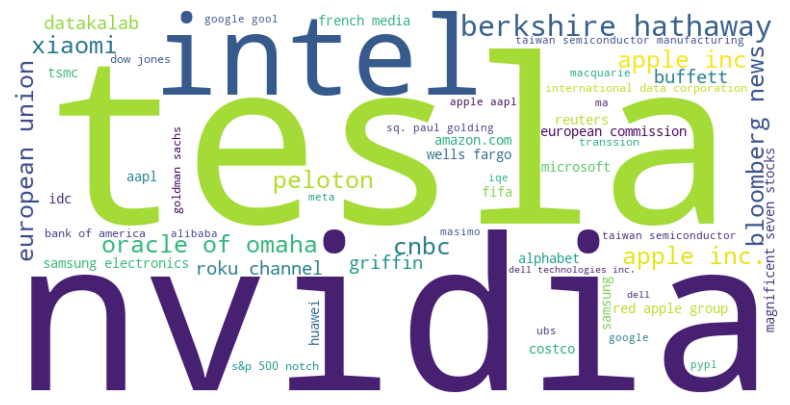

In [122]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'Apple', 'APPLE', 'Apple Corp', 'apple'}
# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_apple_positive['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение


## Облако негативных упоминаний

In [123]:
df_apple_negative = df_apple[df_apple['negative'] > 0.5 ]
df_apple_negative

,date,content,negative,neutral,positive,entities
0,2024-04-24,Apple Apple is expected to publish its Q2 FY'2...,0.998367,0.000891,0.000742,"[Apple, Apple, Apple]"
2,2024-04-24,Doubling Down On Telus In Smith Maneuver - Mar...,0.997623,0.001717,0.000660,[]
3,2024-04-24,"Apple Inc (NASDAQ:AAPL, ETR:APC) is cutting 20...",0.998219,0.001276,0.000505,[Apple Inc]
5,2024-04-24,Microsoft (MSFT) has been caught in a spree of...,0.997714,0.000434,0.001852,[Microsoft]
10,2024-04-23,Apple's smartphone sales declined by 19.1% in ...,0.614353,0.000362,0.385285,"[Apple, Huawei]"
...,...,...,...,...,...,...
290,2024-04-03,"Like it or not, the iPhone's glory days are in...",0.997952,0.001017,0.001031,[]
295,2024-04-03,A powerful earthquake in Taiwan forced chip ma...,0.994470,0.004641,0.000890,"[TSMC, Apple]"
296,2024-04-03,From a Department of Justice lawsuit to slowin...,0.990349,0.000455,0.009196,"[Department of Justice, Apple]"
297,2024-04-02,The stock market is dragging Monday's losses i...,0.997959,0.001121,0.000920,[]


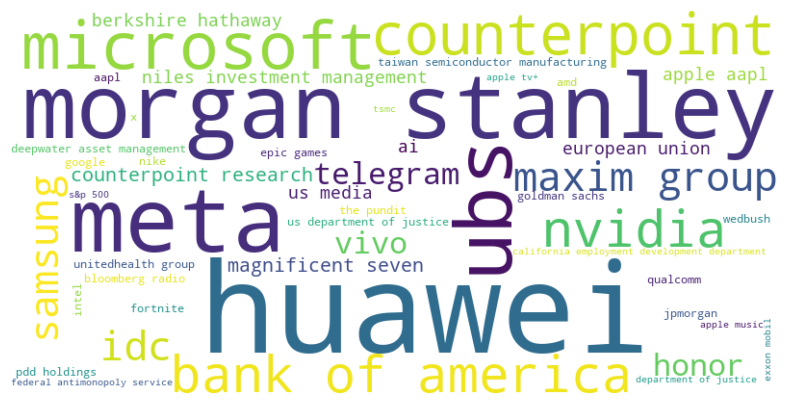

In [138]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Определите набор имен, которые вы хотите исключить или нормализовать
exclude_names = {'Apple', 'APPLE', 'Apple Corp', 'apple', 'apple inc', 'apple inc.', 'bloomberg', 'reuters', 'bloomberg technology'}
# Предположим, у вас есть DataFrame df_series_positive с столбцом 'entities', содержащим списки названий компаний
df_for_word_cloud = df_apple_negative['entities']

# Объединение всех списков компаний в один большой список
all_companies = []
for companies in df_for_word_cloud:
    # Нормализация и фильтрация имен компаний
    normalized_companies = [company.strip().lower() for company in companies]  # Убираем пробелы и приводим к нижнему регистру
    filtered_companies = [company for company in normalized_companies if company not in exclude_names]
    all_companies.extend(filtered_companies)  # Добавляем очищенные и отфильтрованные компании в общий список

# Подсчет частоты упоминания каждой компании
company_counter = Counter(all_companies)  # Используем Counter для подсчета частоты

# Создание словооблака
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(company_counter)  # Генерация из частот

# Визуализация словооблака
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Используем двустороннюю интерполяцию для сглаживания
plt.axis('off')  # Отключаем отображение осей
plt.show()  # Показываем изображение
